In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import * 
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [7]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(g=[0.3, 1, 1.2],
                                 lr=[0.01, 0.001])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

In [8]:
root_name = 'glr_seed_talk'
file_names = []
for params, i_seed in micro_configs:
    
    np.random.seed(i_seed)

    task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
    N_train = int(15000 * (0.01 / params['lr']))
    N_test = 10000
    checkpoint_interval = int(200 * (0.01 / params['lr']))
    sigma = 0
    data = task.gen_data(N_train, N_test)

    n_in = task.n_in
    n_hidden = 32
    n_out = task.n_out

    W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
    W_rec = params['g'] * np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
    W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

    b_rec = np.zeros(n_hidden)
    b_out = np.zeros(n_out)

    alpha = 1
    sigma = 0
    
    rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
              activation=tanh,
              alpha=alpha,
              output=identity,
              loss=mean_squared_error)

    learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
    optimizer = SGD_Momentum(lr=params['lr'], mu=0.6)

    monitors = []

    sim = Simulation(rnn)
    sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
            sigma=sigma,
            monitors=monitors,
            verbose=False,
            report_accuracy=False,
            report_loss=True,
            checkpoint_optimizer=True,
            checkpoint_interval=checkpoint_interval)
    
    file_name = root_name + '_seed={}'.format(i_seed)
    for key in params.keys():
        file_name += '_{}={}'.format(key, str(params[key]).replace('.', ','))
        
    file_names.append(file_name)
    
    print('finish simulation: {}, {}, {}'.format(params['g'],  params['lr'], i_seed))
    if np.isnan(rnn.W_rec[0, 0]):
        print('MISTAKES WERE MADE')
        break
    
    
    ### --- SAVE RUN --- ###
    with open(os.path.join('saved_runs/', file_name), 'wb') as f:
        saved_run = {'sim': sim, 'task': task}
        pickle.dump(saved_run, f)

finish simulation: 0.3, 0.01, 0
finish simulation: 0.3, 0.01, 1
finish simulation: 0.3, 0.01, 2
finish simulation: 0.3, 0.001, 0
finish simulation: 0.3, 0.001, 1
finish simulation: 0.3, 0.001, 2
finish simulation: 1, 0.01, 0
finish simulation: 1, 0.01, 1
finish simulation: 1, 0.01, 2
finish simulation: 1, 0.001, 0
finish simulation: 1, 0.001, 1
finish simulation: 1, 0.001, 2
finish simulation: 1.2, 0.01, 0
finish simulation: 1.2, 0.01, 1
finish simulation: 1.2, 0.01, 2
finish simulation: 1.2, 0.001, 0
finish simulation: 1.2, 0.001, 1
finish simulation: 1.2, 0.001, 2


In [39]:
root_name = 'glr_seed_talk'
cross_topological_analysis(root_name, ppn=16, FP_find_FPs=True, FP_N=800,
                           test_save_data=False, test_N=1200,
                           n_checkpoints_per_job_=10,
                           compare_aligned_graph=True, compare_node_diff=True,
                           compare_weight_change_alignment=False, compare_n_comp_window=1,
                           compare_node_drift=True, compare_SVCCA=False, compare_align_checkpoints=True,
                           compare_CKA=False,
                           compare_PC1=False, compare_PC2=False, compare_PC3=False)

rm: cannot remove '/scratch/oem214/learning-dynamics/results/analyze_glr_seed_talk_seed=0_g=0,3_lr=0,001/result_*': No such file or directory
sending incremental file list

sent 12,019 bytes  received 45 bytes  24,128.00 bytes/sec
total size is 1,375,326  speedup is 114.00
rm: cannot remove '/scratch/oem214/learning-dynamics/results/analyze_glr_seed_talk_seed=0_g=0,3_lr=0,01/result_*': No such file or directory
sending incremental file list

sent 12,019 bytes  received 45 bytes  24,128.00 bytes/sec
total size is 1,375,326  speedup is 114.00
rm: cannot remove '/scratch/oem214/learning-dynamics/results/analyze_glr_seed_talk_seed=0_g=1,2_lr=0,001/result_*': No such file or directory
sending incremental file list

sent 12,019 bytes  received 45 bytes  24,128.00 bytes/sec
total size is 1,375,326  speedup is 114.00
rm: cannot remove '/scratch/oem214/learning-dynamics/results/analyze_glr_seed_talk_seed=0_g=1,2_lr=0,01/result_*': No such file or directory
sending incremental file list

sent 12

In [ ]:
saved_run_root_name = 'alg_comp'
project_name='learning-dynamics'
module_name='vanilla-rtrl'
username='oem214'
ppn=16
n_checkpoints_per_job_=20

analysis_job_ids = []

### --- Identify all saved runs fitting root name --- ###

saved_run_names = [saved_run for saved_run in os.listdir('saved_runs')
                   if saved_run_root_name in saved_run]
saved_run_names = sorted(saved_run_names)

### --- Define relevant paths --- ###

project_dir = os.path.join('/scratch/{}/'.format(username), project_name)
module_dir = os.path.join('/scratch/{}/'.format(username), module_name)
cluster_main_dir = os.path.join(project_dir, 'cluster_main_scripts/')
args_dir = os.path.join(project_dir, 'args')

analyze_main_path = os.path.join(module_dir, 'analyze_main.py')
args_path = os.path.join(args_dir, saved_run_root_name)

### -- Submit compare job script when done

compare_job_name = 'cross_compare_{}'.format(saved_run_root_name)
compare_main_path = os.path.join(module_dir, 'cross_compare_main.py')

analysis_id_dependency = ':'.join([str(id_) for id_ in analysis_job_ids])

write_job_file(compare_job_name, py_file_name='cross_compare_main.py',
               py_args='--name {}'.format(saved_run_root_name), n_hours=8)
get_ipython().system('cp {} {}'.format(compare_main_path, cluster_main_dir))
submit_job('../job_scripts/{}.s'.format(compare_job_name),
           n_array=1,
           py_file_name='cross_compare_main.py',
           id_dependency=None)

In [ ]:
root_name = 'alg_phi_hyperparam'
cross_topological_analysis(root_name, n_checkpoints_per_job_=10, ppn=16)

In [41]:
!squeue -u oem214

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13705443        cm  jupyter   oem214  R    2:41:04      1 cm005
      13709747_[1]     cm,cs cross_co   oem214 PD       0:00      1 (DependencyNeverSatisfied)


In [13]:
!scancel 13708211

In [ ]:
### --- OPEN RUN --- ###
file_name = 'algphi_again_seed=1_learn_alg=DNI_phi=relu'
with open(os.path.join('saved_runs/', file_name), 'rb') as f:
    saved_run = pickle.load(f)
    sim = saved_run['sim']
    task =saved_run['task']

In [ ]:
np.isnan(rnn.W_rec[0, 0])

In [14]:
root_name = 'g_lr_talk'
with open ('../results/cross_compare_{}/result_0'.format(root_name), 'rb') as f:
    result = pickle.load(f)

In [16]:
#from functools import partial
#get_checkpoint_W_rec_dim_ = partial(get_checkpoint_W_rec_dim, W_init=)

root_name = 'g_lr_talk'
signal_dicts = unpack_cross_compare_result(root_name, checkpoint_stats={'loss': get_checkpoint_loss,
                                                                        'n_nodes': get_checkpoint_n_stable_FPs})

In [17]:
root_name = 'g_lr_talk'
results_dir = '/scratch/oem214/learning-dynamics/results/'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

In [5]:
checkpoints_dicts.keys()

dict_keys(['analyze_alg_cheap_comp_seed=1_g=1_learn_alg=RFLO', 'analyze_alg_cheap_comp_seed=3_g=1_learn_alg=DNI', 'analyze_alg_cheap_comp_seed=0_g=1_learn_alg=RFLO', 'analyze_alg_cheap_comp_seed=2_g=1_learn_alg=DNI', 'analyze_alg_cheap_comp_seed=4_g=1_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=3_g=0,3_learn_alg=DNI', 'analyze_alg_cheap_comp_seed=0_g=1_learn_alg=DNI', 'analyze_alg_cheap_comp_seed=1_g=0,3_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=0_g=1_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=0_g=0,3_learn_alg=RFLO', 'analyze_alg_cheap_comp_seed=2_g=0,3_learn_alg=DNI', 'analyze_alg_cheap_comp_seed=1_g=0,3_learn_alg=RFLO', 'analyze_alg_cheap_comp_seed=2_g=0,3_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=3_g=0,3_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=3_g=1_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=2_g=1_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=4_g=0,3_learn_alg=DNI', 'analyze_alg_cheap_comp_seed=1_g=1_learn_alg=BPTT', 'analyze_alg_cheap_comp_seed=4_g=0,3_learn_

<ipython-input-69-a919772739d4>:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dps" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(figs_path, fig_name), dps=300, format='pdf')


(-1.7, 1.7, -1.7, 1.7)

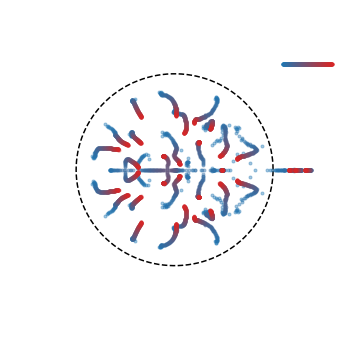

In [69]:
fig = plt.figure(figsize=(6, 6))
plot_range = 1.7
plt.xlim([-plot_range, plot_range])
plt.ylim([-plot_range, plot_range])
theta = np.arange(0, 2 * np.pi, 0.01)
plt.plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
n_eig = 32
job_name = analysis_jobs[1]
indices = checkpoints_dicts[job_name]['indices']
checkpoints = checkpoints_dicts[job_name]['checkpoints']
n_checkpoints = len(indices)

topological_distance = signal_dicts[job_name]['aligned_graph_distances']
i_phase = np.amin(np.where(np.logical_and(topological_distance > 0,
                                          np.roll(topological_distance, -1) > 0,
                                          np.roll(topological_distance, -2) > 0))[0])

for i_index, i_checkpoint in enumerate(indices):
    W = checkpoints['checkpoint_{}'.format(i_checkpoint)]['rnn'].W_rec
    eigs, vecs = np.linalg.eig(W)
    eigs = eigs[np.argsort(np.abs(eigs))[::-1]]
    #col = color_fader('lightgray', 'C3', i_index / n_checkpoints)
    col = color_fader('C0', 'C3', i_index / n_checkpoints)
    plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], '.', color=col, alpha=0.4)
    plt.plot([1.1+i_index / n_checkpoints * 0.5], [1.1], '.', color=col)
    
    if i_index == 0:
        pass
        #plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], '.', color='k')
        
    if i_index == i_phase:
        pass
        #plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], 'x', markersize=10, color='C2')
        
#plt.plot(np.real(eigs)[:3], np.imag(eigs)[:3], 'x', markersize=12, color='C3')
figs_path = 'figs/talk_1-12'
fig_name = 'rflo_spectrum.pdf'
fig.savefig(os.path.join(figs_path, fig_name), dps=300, format='pdf')
plt.axis('off')

<ipython-input-70-6cdd1856b356>:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dps" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(figs_path, fig_name), dps=300, format='pdf')


(-1.7, 1.7, -1.7, 1.7)

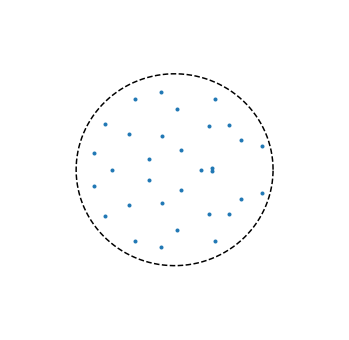

In [70]:
fig = plt.figure(figsize=(6, 6))
plot_range = 1.7
plt.xlim([-plot_range, plot_range])
plt.ylim([-plot_range, plot_range])
theta = np.arange(0, 2 * np.pi, 0.01)
plt.plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
n_eig = 32
job_name = analysis_jobs[1]
indices = checkpoints_dicts[job_name]['indices']
checkpoints = checkpoints_dicts[job_name]['checkpoints']
n_checkpoints = len(indices)

topological_distance = signal_dicts[job_name]['aligned_graph_distances']
i_phase = np.amin(np.where(np.logical_and(topological_distance > 0,
                                          np.roll(topological_distance, -1) > 0,
                                          np.roll(topological_distance, -2) > 0))[0])

for i_index, i_checkpoint in enumerate(indices):
    W = checkpoints['checkpoint_{}'.format(i_checkpoint)]['rnn'].W_rec
    eigs, vecs = np.linalg.eig(W)
    eigs = eigs[np.argsort(np.abs(eigs))[::-1]]
    col = color_fader('C0', 'C2', i_index / n_checkpoints)
    #plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], '.', color=col, alpha=0.4)
    
    if i_index == 0:
        plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], '.', color='C0')
        
    #if i_index == i_phase:
    #    plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], 'x', markersize=10, color='C3')
    
    plt.axis('off')
    
figs_path = 'figs/talk_1-12'
fig_name = 'rflo_spectrum_init.pdf'
fig.savefig(os.path.join(figs_path, fig_name), dps=300, format='pdf')
plt.axis('off')

In [20]:
analysis_jobs

['analyze_g_lr_talk_seed=0_g=0,3_lr=0,0001',
 'analyze_g_lr_talk_seed=0_g=1_lr=0,0001',
 'analyze_g_lr_talk_seed=0_g=0,3_lr=0,001',
 'analyze_g_lr_talk_seed=0_g=1_lr=0,001',
 'analyze_g_lr_talk_seed=0_g=1,2_lr=0,01',
 'analyze_g_lr_talk_seed=0_g=0,1_lr=0,01',
 'analyze_g_lr_talk_seed=0_g=0,1_lr=0,0001',
 'analyze_g_lr_talk_seed=0_g=1,2_lr=0,0001',
 'analyze_g_lr_talk_seed=0_g=0,3_lr=0,01',
 'analyze_g_lr_talk_seed=0_g=0,1_lr=0,001',
 'analyze_g_lr_talk_seed=0_g=1,2_lr=0,001',
 'analyze_g_lr_talk_seed=0_g=1_lr=0,01']

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))
n_seeds = 5

gs = [0.3, 1]
learn_algs = ['RFLO', 'DNI', 'BPTT']
for i_x in range(2):
    for i_y in range(3):
        for i_seed in range(n_seeds):

In [ ]:
analysis_jobs

In [ ]:
signal_dicts['analyze_rflo_postfix_dense10_seed=1']['rec_weight_distances']

In [ ]:
[[signal_dicts[k][k_].shape for k_ in signal_dicts[k].keys()] for k in signal_dicts.keys()]

In [ ]:
signal_dicts_list[0]['A_PC']

In [ ]:
signal_dicts.keys()

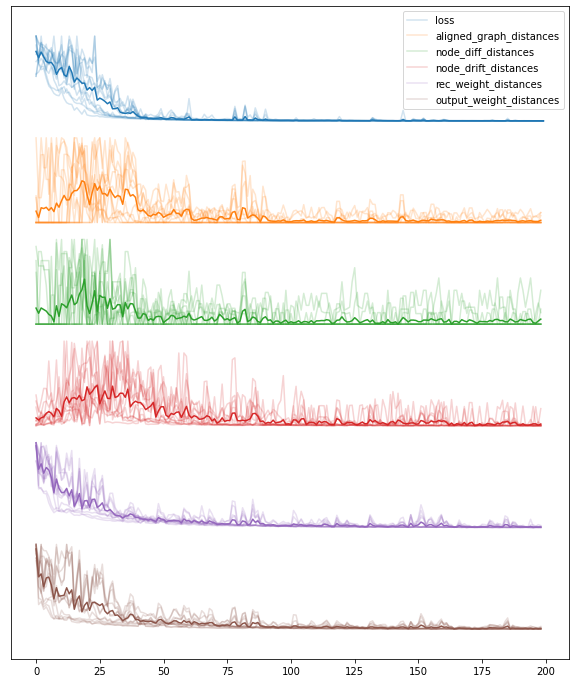

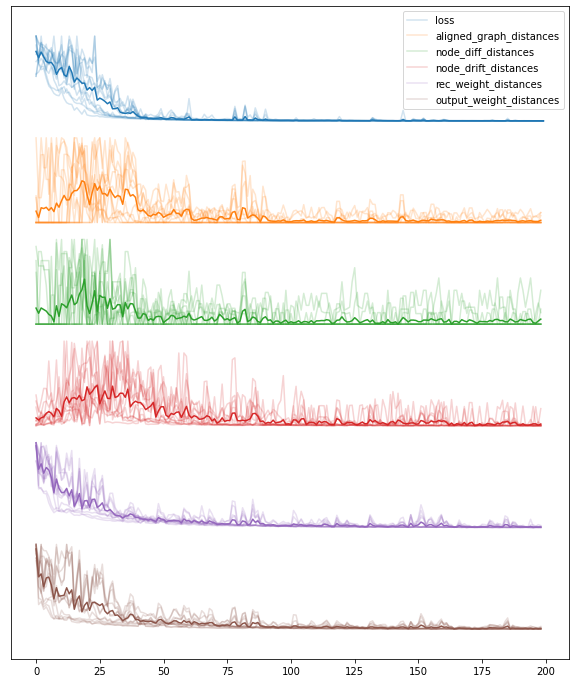

In [14]:
signal_dicts_list = [v for v in signal_dicts.values()]
#signal_dicts_list = [signal_dicts[k] for k in signal_dicts.keys() if ('0,01' in k and '32' in k)]
plot_multiple_signals(signal_dicts_list, key_restriction=None, alpha=0.2)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))
n_seeds = 5

gs = [0.3, 1]
learn_algs = ['RFLO', 'DNI', 'BPTT']
for i_x in range(2):
    for i_y in range(3):
        for i_seed in range(n_seeds):
            
            key = 'analyze_alg_cheap_comp_seed={}_g={}_learn_alg={}'.format(i_seed, gs[i_x], learn_algs[i_y]).replace('.', ',')
            ax[i_y, i_x].plot(signal_dicts[key]['aligned_graph_distances'], color='C0', alpha=0.6)
            
            if i_seed == 0:
                ax[i_y, i_x].set_title(key.split('seed=0_')[-1])
            
figs_path = 'figs/alg_cheap_comp/'
file_name = 'alg_cheap_comp_array.pdf'
#file_name = 'g_lr_Wstd_seed{}.pdf'.format(n_seed)
fig.savefig(os.path.join(figs_path, file_name), dpi=300, format='pdf')

In [ ]:
plt.plot(signal_dicts_list[0]['aligned_graph_distances'])

In [ ]:
top = signal_dicts_list[0]['aligned_graph_distances']
np.amin(np.where(top > 0)[0])

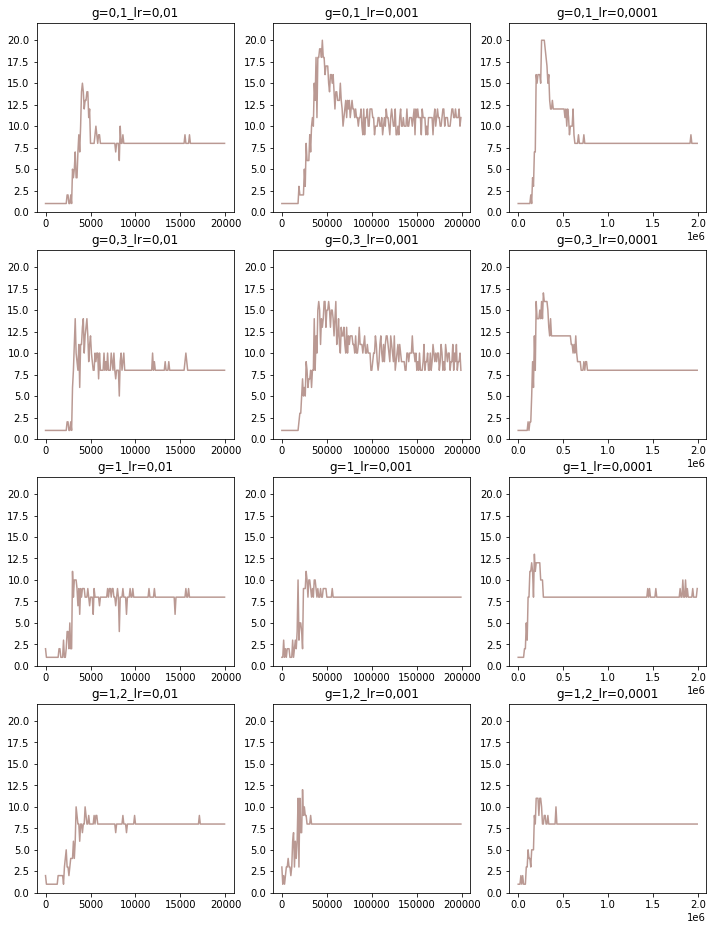

In [30]:
fig, ax = plt.subplots(4, 3, figsize=(12, 16))
n_seed = 0

gs = [0.1, 0.3, 1, 1.2]
lrs = [0.01, 0.001, 0.0001]
for i_x in range(4):
    for i_y in range(3):
        for i_seed in range(n_seed, n_seed + 1):
            
            T = int(200 / lrs[i_y])
            CI = int(1 / lrs[i_y])
            
            key = 'analyze_g_lr_talk_seed={}_g={}_lr={}'.format(i_seed, gs[i_x], lrs[i_y]).replace('.', ',')
            #ax[i_x, i_y].plot(np.arange(CI, T, CI), signal_dicts[key]['aligned_graph_distances'], color='C0', alpha=0.6)
            #ax[i_x, i_y].plot(np.arange(0, T, CI), signal_dicts[key]['loss'], color='C7', alpha=0.6)
            ax[i_x, i_y].plot(np.arange(0, T, CI), signal_dicts[key]['n_nodes'], color='C5', alpha=0.6)
            
            if i_seed == 0:
                ax[i_x, i_y].set_title(key.split('seed=0_')[-1])
            
        ax[i_x, i_y].set_ylim([0, 22])
        
        
figs_path = 'figs/talk_1-12/'
file_name = 'g_lr_n_nodes.pdf'
fig.savefig(os.path.join(figs_path, file_name), dpi=300, format='pdf')

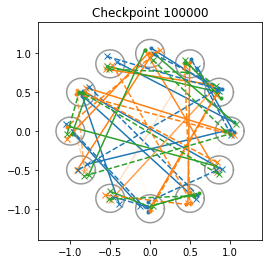

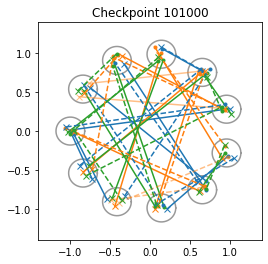

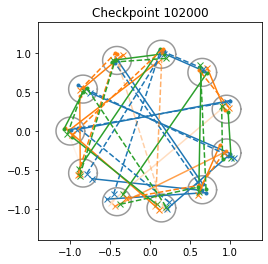

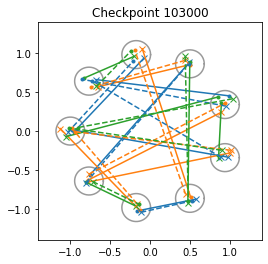

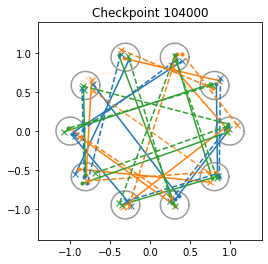

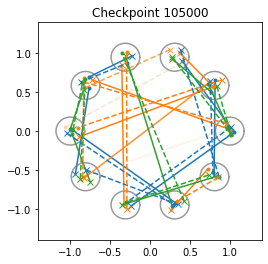

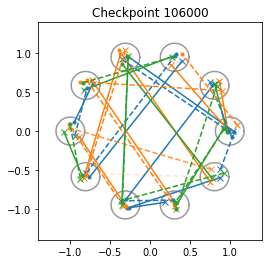

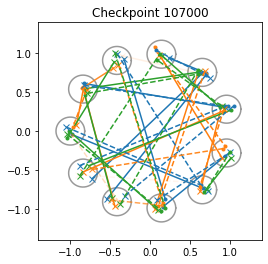

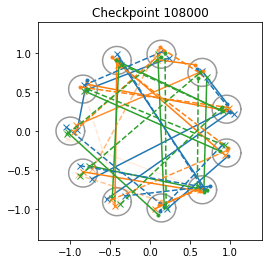

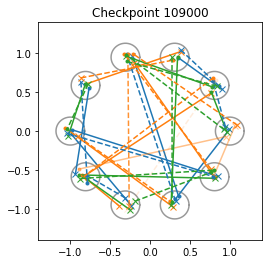

In [32]:
for i in range(100000, 110000, 1000):
    plot_input_dependent_topology(checkpoints_dicts['analyze_g_lr_talk_seed=0_g=0,1_lr=0,001']['checkpoints']['checkpoint_{}'.format(i)])

In [ ]:
#aligned thing
for i_stat in range(6):
    fig, ax = plt.subplots(4, 2, figsize=(12, 16))

    #i_stat = 5
    stats = ['W_PC', 'A_PC', 'W_SR', 'W_mean', 'W_std', 'loss']
    stat = stats[i_stat]

    y_min = np.inf
    y_max = -np.inf

    gs = [0.3, 0.6, 1, 1.2]
    lrs = [0.01, 0.001]
    for i_x in range(4):
        for i_y in range(2):
            for i_seed in range(5):

                T = int(40 / lrs[i_y])
                CI = int(0.5 / lrs[i_y])

                x = np.arange(0, T, CI)

                key = 'analyze_phase_1_deep_seed={}_g={}_lr={}'.format(i_seed, gs[i_x], lrs[i_y]).replace('.', ',')
                topological_distance = signal_dicts[key]['aligned_graph_distances']
                x_align = np.amin(np.where(np.logical_and(topological_distance > 0,
                                                          np.roll(topological_distance, -1) > 0,
                                                          np.roll(topological_distance, -2) > 0))[0]) * CI
                
                
                y_stat = signal_dicts[key][stat]
                ax[i_x, i_y].plot(x - x_align, y_stat, color='C{}'.format(i_stat + 1), alpha=0.6)
                ax[i_x, i_y].axvline(x=0, color='k', linestyle='--')

                if np.amin(y_stat) < y_min:
                    y_min = np.amin(y_stat)
                if np.amax(y_stat) > y_max:
                    y_max = np.amax(y_stat)

                if i_seed == 0:
                    ax[i_x, i_y].set_title(key.split('seed=0_')[-1])

    for i_x in range(4):
        for i_y in range(2):
            diff = y_max - y_min
            ax[i_x, i_y].set_ylim([y_min - 0.05 * diff, y_max + 0.05 * diff])

    figs_path = 'figs/phase_1'
    file_name = 'g_lr_{}_aligned_roll2.pdf'.format(stat)
    #fig.savefig(os.path.join(figs_path, file_name), dpi=300, format='pdf')

In [ ]:
#aligned thing
fig, ax = plt.subplots(4, 2, figsize=(12, 16))

#i_stat = 5
#stats = ['W_PC', 'A_PC', 'W_SR', 'W_mean', 'W_std', 'loss']
#stat = stats[i_stat]

y_min = np.inf
y_max = -np.inf

gs = [0.3, 0.6, 1, 1.2]
lrs = [0.01, 0.001]
for i_x in range(4):
    for i_y in range(2):
        for i_seed in range(5):

            T = int(40 / lrs[i_y])
            CI = int(0.5 / lrs[i_y])

            x = np.arange(0, T, CI)

            key = 'analyze_phase_1_deep_seed={}_g={}_lr={}'.format(i_seed, gs[i_x], lrs[i_y]).replace('.', ',')
            topological_distance = signal_dicts[key]['aligned_graph_distances']
            x_align = np.amin(np.where(topological_distance > 0)[0]) * CI

            colors = ['C3', 'C7', 'C8']
            for i_stat, stat in enumerate(['W_SR', 'W_2eig', 'W_3eig']):
                col = colors[i_stat]
                y_stat = signal_dicts[key][stat]
                ax[i_x, i_y].plot(x - x_align, y_stat, color=col, alpha=0.6)
                ax[i_x, i_y].axvline(x=0, color='k', linestyle='--')

                if np.amin(y_stat) < y_min:
                    y_min = np.amin(y_stat)
                if np.amax(y_stat) > y_max:
                    y_max = np.amax(y_stat)

            if i_seed == 0:
                ax[i_x, i_y].set_title(key.split('seed=0_')[-1])

for i_x in range(4):
    for i_y in range(2):
        diff = y_max - y_min
        ax[i_x, i_y].set_ylim([y_min - 0.05 * diff, y_max + 0.05 * diff])

figs_path = 'figs/phase_1'
file_name = 'g_lr_{}_aligned_0roll_3eigs.pdf'.format(stat)
fig.savefig(os.path.join(figs_path, file_name), dpi=300, format='pdf')

In [ ]:
np.roll(topological_distance, -1)

In [ ]:
np.absolute(1+1j)

In [ ]:
0 > np.inf

In [ ]:
indices, checkpoints = unpack_analysis_results('/scratch/oem214/learning-dynamics/results/analyze_phase_1_deep_seed=0_g=0,3_lr=0,001/')

In [ ]:
checkpoints.keys()

In [ ]:
eigs, vecs = np.linalg.eig(checkpoints['checkpoint_39000']['rnn'].W_rec)

In [ ]:
plt.plot(np.abs(eigs))

In [ ]:
abs_eigs = np.abs(eigs)
np.square(np.sqrt(abs_eigs).sum()) / abs_eigs.sum()

In [ ]:
M = result['aligned_graph_distances']
M = M + M.T
fig = plt.figure()
plt.imshow(M, cmap='RdBu_r')

In [ ]:
plt.figure()
plt.imshow(result['calculation_check'])

In [ ]:
i_1 = 4900
i_2 = 4905

checkpoint_1 = checkpoints['checkpoint_{}'.format(i_1)]
checkpoint_2 = checkpoints['checkpoint_{}'.format(i_2)]

print(M[indices.index(i_1), indices.index(i_2)])

align_checkpoints_based_on_output(checkpoint_2, checkpoint_1, n_inputs=6)
plot_input_dependent_topology(checkpoint_1)
plot_input_dependent_topology(checkpoint_2)

In [ ]:
plt.hist(np.log10(M + 0.0001).flatten(), bins=100)

In [ ]:
figs_path = 'figs/geometry/'
for dist in ['PC1_distances', 'PC2_distances', 'PC3_distances']:
    M = result[dist]
    M = M + M.T
    fig = plt.figure()
    #plt.imshow(np.log10(M + 0.001))
    plt.imshow(M)
    plt.colorbar()
    
    file_name = (dist+'_mat.pdf').replace('_', '-')
    fig.savefig(os.path.join(figs_path, file_name), dpi=300, format='pdf')
    
    colors = ['C0', 'C1'] * 20
    fig = plot_3d_MDS_from_distance_matrix(M, np.array(result['job_indices']), alpha=0.2, colors=colors, return_fig=True)
    file_name = (dist+'_mds.pdf').replace('_', '-')
    fig.savefig(os.path.join(figs_path, file_name), dpi=300, format='pdf')

In [ ]:
C = np.random.normal(0, 1, (1000, 3))
W1 = np.random.normal(0, 1, (3, 100))
W2 = np.random.normal(0, 1, (3, 100))
A = C.dot(W1)
B = C.dot(W2)

cca = CCA(n_components=3)
cca.fit(A, B)
cca.score(A, B)

In [ ]:
%matplotlib notebook
M = result['aligned_graph_distances']
M = M + M.T
colors = ['C0', 'C1'] * 4
plot_3d_MDS_from_distance_matrix(M, np.array(result['job_indices']), alpha=0.2, colors=colors)

In [ ]:
colors = ['C0'] * 1
plot_3d_tSNE_from_distance_matrix(relu.f(M[:2000,:2000]), np.array(result['job_indices'][:2000]), alpha=0.2, colors=colors)

In [ ]:
%matplotlib notebook
colors = ['C0', 'C1'] * 5
fig = plot_3d_MDS_from_distance_matrix(np.abs(np.log10(M+0.001)), np.array(result['job_indices']),
                                       alpha=0.2, colors=colors,
                                       return_fig=True)

In [ ]:
figs_path = 'figs/geometry/'
file_name = ('tanhrelu_svcca'+'_mds.pdf').replace('_', '-')
fig.savefig(os.path.join(figs_path, file_name), dpi=300, format='pdf')

In [ ]:
result['job_indices']

In [ ]:
saved_run_root_name = root_name
saved_runs_dir = 'saved_runs/'
analysis_job_names = ['analyze_' + sr for sr in os.listdir(saved_runs_dir)
                      if saved_run_root_name in sr]
analysis_job_names = sorted(analysis_job_names)

In [ ]:
analysis_job_names

In [ ]:
plt.figure()
plt.hist(np.log10(M.flatten()+0.0001), bins=100)

In [ ]:
signals = unpack_compare_result('cross_compare_tanhrelu_svcca', checkpoint_stats={'test_loss': get_checkpoint_loss})

In [ ]:
!ls ../results/compare_tanhrelu*